In [1]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score

import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression

In [2]:
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from transformers import get_constant_schedule_with_warmup
from sklearn.metrics import precision_score,recall_score,accuracy_score

from src.train import trainModel
from src.dataloader import getData,spliceDataset,h5pyDataset,getDataPointList,getDataPointListFull,DataPoint
from src.weight_init import keras_init
from src.losses import categorical_crossentropy_2d
from src.model import SpliceFormer
from src.evaluation_metrics import print_topl_statistics
import copy
#import tensorflow as tf

In [3]:
!nvidia-smi

Thu Jun 27 11:55:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:31:00.0 Off |                    0 |
| N/A   36C    P0             38W /  250W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
#snps = df.drop_duplicates(subset=['not_sQTL'])['not_sQTL'].values
#res = pd.DataFrame({'Chr':[x.split(':')[0] for x in snps],'Pos':[int(x.split(':')[1]) for x in snps],'marker':snps})
#res.sort_values(['Chr','Pos'],ascending=True).to_csv('../Data/not_sQTL.gor',sep='\t',index=False)

In [5]:
import pyfastx
import gffutils
data_dir = '../Data/'
fasta_file_path = '../Data/genome.fa'
gtf_file_path = '/odinn/tmp/benediktj/Data/SplicePrediction-GTEX/gencode.v26.annotation.gtf'
#fname = data_dir+gtf_file_path.split('/')[-1][:-4]+'.db'
#gtf = gffutils.FeatureDB(fname)
fasta = pyfastx.Fasta(fasta_file_path)

In [6]:
!ls /odinn/tmp/benediktj/Data/SplicePrediction-GTEX/gencode.v26.annotation.gtf

/odinn/tmp/benediktj/Data/SplicePrediction-GTEX/gencode.v26.annotation.gtf


In [6]:
import pandas as pd

def parse_gtf(gtf_file):
    """Parse GTF file and return a DataFrame."""
    columns = [
        'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'
    ]
    df = pd.read_csv(gtf_file, sep='\t', comment='#', names=columns)
    
    # Filter for genes only
    df = df[df['feature'] == 'gene']
    
    # Parse attributes to get gene_id and gene_name
    df['gene_id'] = df['attribute'].str.extract('gene_id "([^"]+)"')
    df['gene_name'] = df['attribute'].str.extract('gene_name "([^"]+)"')
    
    return df[['gene_id', 'gene_name', 'seqname', 'start', 'end', 'strand']]

def get_gene_info(gene_names, gtf_file):
    """Return gene information for a list of gene names."""
    gtf_data = parse_gtf(gtf_file)
    
    # Filter for the genes of interest
    gene_info = gtf_data[gtf_data['gene_name'].isin(gene_names)]
    
    return gene_info



In [7]:
rng = np.random.default_rng(23673)

In [8]:
data_dir = '../Data'

In [9]:
L = 32
N_GPUS = 4
k = 2
# Hyper-parameters:
# L: Number of convolution kernels
# W: Convolution window size in each residual unit
# AR: Atrous rate in each residual unit

W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])
BATCH_SIZE = k*6*N_GPUS


CL = 2 * np.sum(AR*(W-1))

In [10]:
SL=5000
CL_max=40000

In [11]:
#lead_sQTL = lead_sQTL[lead_sQTL['Pval']<=0.05/lead_sQTL.shape[0]]

In [12]:
clinvar = pd.read_csv('/odinn/tmp/benediktj/Data/ClinVar/clinvar_splice_variants.tsv',sep='\t')
gene_names = clinvar.gene_info.apply(lambda x: x.split(':')[0]).unique()
gene_info = get_gene_info(gene_names, gtf_file_path)
clinvar['gene_name'] = clinvar.gene_info.apply(lambda x: x.split(':')[0])
gene_info = gene_info.drop_duplicates('gene_name')
clinvar = clinvar.merge(gene_info,on='gene_name',how='left')
clinvar = clinvar[clinvar['chromosome'].isin([str(x) for x in list(range(1,23))])]
clinvar = clinvar.dropna()

In [13]:
NUM_ACCUMULATION_STEPS = 1
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]

[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_finetune_GTEX_131222_{}'.format(i))) for i,model in enumerate(models)]

for model in models:
    model.eval()

In [14]:
#gene_boundries = {}
#for gene in tqdm(genes):
#    gene_boundries[gene["gene_name"][0]] = [int(gene[3]),int(gene[4])]

In [15]:
#with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/gene_boundries.pkl', 'wb') as f:
#    pickle.dump(gene_boundries, f)

In [16]:
#no_sQTLs = pd.read_csv('../Data/no_sQTLs.csv')

In [17]:
def predictSplicing(seq,models):
    outputs = []
    for i in range(seq.shape[0]):
        batch_features = torch.tensor(seq[i,:,:], device=device).float().unsqueeze(0)
        batch_features = torch.swapaxes(batch_features,1,2)
        prediction = ([models[i](batch_features)[0].detach() for i in range(n_models)])
        prediction = torch.stack(prediction)
        prediction = torch.mean(prediction,dim=0)
        outputs.append(prediction)
    
    outputs = torch.cat(outputs,dim=2)
    outputs = outputs.cpu().detach().numpy()
    return outputs

def plotPrediction(outputs):
    plt.rcParams.update({'font.size': 18})
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(22, 6),sharex=True)
    x = np.arange(outputs.shape[2])
    ax1.plot(x,outputs[0,1,:],linewidth=2,zorder=-32)
    ax2.plot(x,outputs[0,2,:],linewidth=2,zorder=-32)
    plt.xlabel('Distance from transcript start (nt)')
    ax1.set_ylabel('Acceptor score')
    ax2.set_ylabel('Donor Score')
    ax1.legend(prop={'size': 14})
    ax2.legend(prop={'size': 14})
    plt.tight_layout()
    plt.show()

def ceil_div(x, y):

    return int(ceil(float(x)/y))


IN_MAP = np.asarray([[0, 0, 0, 0],
                     [1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

def one_hot_encode(Xd):

    return IN_MAP[Xd.astype('int8')]

def reformat_data(X0):
    # This function converts X0, Y0 of the create_datapoints function into
    # blocks such that the data is broken down into data points where the
    # input is a sequence of length SL+CL_max corresponding to SL nucleotides
    # of interest and CL_max context nucleotides, the output is a sequence of
    # length SL corresponding to the splicing information of the nucleotides
    # of interest. The CL_max context nucleotides are such that they are
    # CL_max/2 on either side of the SL nucleotides of interest.

    num_points = ceil_div(len(X0)-CL_max, SL)
    Xd = np.zeros((num_points, SL+CL_max))
    X0 = np.pad(X0, [0, SL], 'constant', constant_values=0)

    for i in range(num_points):
        Xd[i] = X0[SL*i:CL_max+SL*(i+1)]

    return Xd

def seqToArray(seq,strand):
    seq = 'N'*(CL_max//2) + seq + 'N'*(CL_max//2)
    seq = seq.upper()
    seq = re.sub(r'[^AGTC]', '0',seq)
    seq = seq.replace('A', '1').replace('C', '2')
    seq = seq.replace('G', '3').replace('T', '4').replace('N', '0')
    if strand == '+':
        X0 = np.asarray([int(x) for x in seq])
            
    elif strand == '-':
        X0 = (5-np.asarray([int(x) for x in seq[::-1]])) % 5  # Reverse complement
        
    Xd = reformat_data(X0)
    return  one_hot_encode(Xd)

In [18]:
def calculate_chromosome_lengths(fasta_file):
    """
    Calculate lengths of chromosomes from a FASTA file.

    Parameters:
    fasta_file (str): Path to the FASTA file.

    Returns:
    dict: A dictionary with chromosome names as keys and their lengths as values.
    """
    chromosome_lengths = {}
    
    fasta = pyfastx.Fasta(fasta_file)
    
    for seq in fasta:
        chromosome_lengths[seq.name] = len(seq)
    
    return chromosome_lengths

In [19]:
chromosome_lengths = calculate_chromosome_lengths(fasta_file_path)
print(chromosome_lengths)

{'chr1': 248956422, 'chr10': 133797422, 'chr11': 135086622, 'chr11_KI270721v1_random': 100316, 'chr12': 133275309, 'chr13': 114364328, 'chr14': 107043718, 'chr14_GL000009v2_random': 201709, 'chr14_GL000194v1_random': 191469, 'chr14_GL000225v1_random': 211173, 'chr14_KI270722v1_random': 194050, 'chr14_KI270723v1_random': 38115, 'chr14_KI270724v1_random': 39555, 'chr14_KI270725v1_random': 172810, 'chr14_KI270726v1_random': 43739, 'chr15': 101991189, 'chr15_KI270727v1_random': 448248, 'chr16': 90338345, 'chr16_KI270728v1_random': 1872759, 'chr17': 83257441, 'chr17_GL000205v2_random': 185591, 'chr17_KI270729v1_random': 280839, 'chr17_KI270730v1_random': 112551, 'chr18': 80373285, 'chr19': 58617616, 'chr1_KI270706v1_random': 175055, 'chr1_KI270707v1_random': 32032, 'chr1_KI270708v1_random': 127682, 'chr1_KI270709v1_random': 66860, 'chr1_KI270710v1_random': 40176, 'chr1_KI270711v1_random': 42210, 'chr1_KI270712v1_random': 176043, 'chr1_KI270713v1_random': 40745, 'chr1_KI270714v1_random': 417

In [20]:
results = {}

for i in tqdm(range(clinvar.shape[0])):
    gene,chrm,strand,pos,gene_start,gene_end,ref_s,alt_s, = clinvar.iloc[i,:][['gene_name','seqname','strand','position','start','end','ref','alt']]
    event_id = i
    names = gene.split(',')
    #gene_start,gene_end = unionBoundry(names,gene_boundries)
    #starts,ends = [],[]
    #if pos<jn_start:
    start,end = np.max([pos-CL_max//2-SL//2,1]),np.min([pos+CL_max//2+SL//2,chromosome_lengths[chrm]])
    #start,end = np.max([pos-CL_max//2,gene_start]),np.min([pos+CL_max//2,gene_end])
    #elif jn_start<=pos<jn_end:
    #    start,end = np.max([jn_start-CL_max//2,gene_start]),np.min([jn_end+CL_max//2,gene_end])
    #else:
    #    start,end = np.max([jn_start-CL_max//2,gene_start]),np.min([pos+CL_max//2,gene_end])
    if start < 1:
        start = 1
    #for name in names:
    #    tmp = gene_boundries[name]
    #    starts.append(tmp[0])
    #    ends.append(tmp[1])

    #gene_start,gene_end = np.min(starts),np.max(ends)

     #= df_gene[].iloc[0]
    #start,end = np.max([pos-CL_max//2,gene_start]),np.min([pos+CL_max//2,gene_end])

    #if strand=='-':
    #    starts,ends = [],[]
    #    for i in range(df_gene.shape[0]):
    #        starts.append(pos+df_gene['acceptor'].iloc[i]-CL_max//2)
    #        ends.append(pos+df_gene['donor'].iloc[i]+CL_max//2)
    #    start2,end2 = np.min(starts),np.max(ends)
    #    start = np.min([start,start2])
    #    end = np.max([end,end2])
    #else:
    #    starts,ends = [],[]
    #    for i in range(df_gene.shape[0]):
    #        starts.append(pos-df_gene['donor'].iloc[i]-CL_max//2)
    #        ends.append(pos-df_gene['acceptor'].iloc[i]+CL_max//2)
    #    start2,end2 = np.min(starts),np.max(ends)
    #    start = np.min([start,start2])
    #    end = np.max([end,end2])

    
    try:
        pos_s = pos-start
        ref = fasta[chrm][start-1:end].seq
        alt = ref
        ref_len = len(ref_s)
        alt_len = len(alt_s)
        assert ref_s == ref[pos_s:(pos_s+ref_len)]
        alt = alt[:pos_s]+alt_s+alt[(pos_s+ref_len):]
        alt_align = np.arange(len(ref))
        alt_align = np.concatenate([alt_align[:pos_s],np.repeat(pos_s,alt_len),alt_align[pos_s+ref_len:]])

        ref_len2 = len(ref)
        alt_len2 = len(alt)

        ref = seqToArray(ref,strand)
        alt = seqToArray(alt,strand)

        ref_prediction = predictSplicing(ref,models)[0,:,:ref_len2]
        alt_prediction = predictSplicing(alt,models)[0,:,:alt_len2]

        tmp = np.zeros_like(ref_prediction)
        if strand=='-':
            ref_prediction = ref_prediction[:,::-1]
            alt_prediction = alt_prediction[:,::-1]

        ref_acceptor = ref_prediction[1,:]
        alt_acceptor = alt_prediction[1,:]
        ref_donor = ref_prediction[2,:]
        alt_donor = alt_prediction[2,:]

        delta_1_a = alt_acceptor[:pos_s]-ref_acceptor[:pos_s]
        delta_1_d = alt_donor[:pos_s]-ref_donor[:pos_s]
        delta_3_a = alt_acceptor[pos_s+alt_len:]-ref_acceptor[pos_s+ref_len:]
        delta_3_d = alt_donor[pos_s+alt_len:]-ref_donor[pos_s+ref_len:]

        if ref_len2==alt_len2:
            delta_2_a = alt_acceptor[pos_s:pos_s+ref_len]-ref_acceptor[pos_s:pos_s+ref_len]
            delta_2_d = alt_donor[pos_s:pos_s+ref_len]-ref_donor[pos_s:pos_s+ref_len]
        elif ref_len2>alt_len2:
            a_pad = np.pad(alt_acceptor[pos_s:pos_s+alt_len],(0, ref_len-alt_len), 'constant', constant_values=0)
            d_pad = np.pad(alt_donor[pos_s:pos_s+alt_len],(0, ref_len-alt_len), 'constant', constant_values=0)
            delta_2_a = a_pad-ref_acceptor[pos_s:pos_s+ref_len]
            delta_2_d = d_pad-ref_donor[pos_s:pos_s+ref_len]

        elif ref_len2<alt_len2:
            a_pad = np.pad(ref_acceptor[pos_s:pos_s+ref_len],(0, alt_len-ref_len), 'constant', constant_values=0)
            d_pad = np.pad(ref_donor[pos_s:pos_s+ref_len],(0, alt_len-ref_len), 'constant', constant_values=0)
            delta_2_a = alt_acceptor[pos_s:pos_s+alt_len]-a_pad
            delta_2_d = alt_donor[pos_s:pos_s+alt_len]-d_pad

            delta_2_a =np.append(delta_2_a[:ref_len-1],delta_2_a[np.argmax(np.absolute(delta_2_a[ref_len-1:alt_len]))])
            delta_2_d =np.append(delta_2_d[:ref_len-1],delta_2_d[np.argmax(np.absolute(delta_2_d[ref_len-1:alt_len]))])

        acceptorDelta = np.concatenate([delta_1_a,delta_2_a,delta_3_a])
        donorDelta = np.concatenate([delta_1_d,delta_2_d,delta_3_d])

        #if strand=='-':
        #    acceptor_loc =jn_start-start
        #    donor_loc = jn_end-start+1
        #else:
        #    acceptor_loc = jn_end-start+1
        #    donor_loc = jn_start-start

        #acceptor_delta_nr = alt_acceptor.shape[0]-np.argsort(np.argsort(np.absolute(acceptorDelta)))[acceptor_loc]
        #donor_delta_nr = alt_donor.shape[0]-np.argsort(np.argsort(np.absolute(donorDelta)))[donor_loc]
        top_a_creation_pos = np.argmax(acceptorDelta)
        top_d_creation_pos = np.argmax(donorDelta)
        top_a_disruption_pos = np.argmin(acceptorDelta)
        top_d_disruption_pos = np.argmin(donorDelta)
        top_a_creation_delta = acceptorDelta[top_a_creation_pos]
        top_d_creation_delta = donorDelta[top_d_creation_pos]
        top_a_disruption_delta = acceptorDelta[top_a_disruption_pos]
        top_d_disruption_delta = donorDelta[top_d_disruption_pos]

        results[event_id] = [start+top_a_creation_pos,start+top_d_creation_pos,start+top_a_disruption_pos,start+top_d_disruption_pos,top_a_creation_delta,top_d_creation_delta,-top_a_disruption_delta,-top_d_disruption_delta]
    except:
        results[event_id] = [float("nan")]*8
        print('{} failed'.format(event_id))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46073/46073 [50:18:33<00:00,  3.93s/it]


In [21]:
with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/clinvar_deltas_transformer_gtex_only_130623.pkl', 'wb') as f:
    pickle.dump(results, f)

In [22]:
with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/clinvar_deltas_transformer_gtex_only_130623.pkl', 'rb') as f:
    results_1 = pickle.load(f)
    
with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/clinvar_deltas_splice_ai_pretrained_130623.pkl', 'rb') as f:
    results_2 = pickle.load(f)

In [23]:
benign_class = ['Benign', 'Likely_benign','Benign/Likely_benign','Likely_benign|drug_response|other']

pathogenic_class = ['Pathogenic','Pathogenic/Likely_pathogenic', 'Likely_pathogenic','Pathogenic/Likely_pathogenic|other', 'Pathogenic|association', 'Pathogenic|risk_factor','Pathogenic|Affects', 'Likely_pathogenic/Likely_risk_allele']

In [24]:
benign = clinvar['clinical_significance'].isin(benign_class)
pathogenic = clinvar['clinical_significance'].isin(pathogenic_class)
in_evaluation_set = clinvar['clinical_significance'].isin(benign_class+pathogenic_class)

In [25]:
acc = np.sum(pd.DataFrame(results_1).T[[4,5,6,7]].max(axis=1)>0.5)/len(results_1)
print(f'Transformer clinvar accuracy: {acc}')

Transformer clinvar accuracy: 0.9264862283767066


In [26]:
acc = np.sum(pd.DataFrame(results_2).T[[4,5,6,7]].max(axis=1)>0.5)/len(results_2)
print(f'SpliceAI clinvar accuracy: {acc}')

SpliceAI clinvar accuracy: 0.9196926616456493


In [27]:
acc = np.sum(pd.DataFrame(results_1).T[[4,5,6,7]][benign.values].max(axis=1)<0.5)/np.sum(benign)
print(f"Transformer clinvar (benign) accuracy: {acc}")

Transformer clinvar (benign) accuracy: 0.5634365634365635


In [28]:
acc = np.sum(pd.DataFrame(results_2).T[[4,5,6,7]][benign.values].max(axis=1)<0.5)/np.sum(benign)
print(f"SpliceAI clinvar (Benign) accuracy: {acc}")

SpliceAI clinvar (Benign) accuracy: 0.5724275724275725


In [29]:
acc = np.sum(pd.DataFrame(results_1).T[[4,5,6,7]][pathogenic.values].max(axis=1)>0.5)/np.sum(pathogenic)
print(f"Transformer clinvar (Pathogenic) accuracy: {acc}")

Transformer clinvar (Pathogenic) accuracy: 0.9651759530791789


In [30]:
acc = np.sum(pd.DataFrame(results_2).T[[4,5,6,7]][pathogenic.values].max(axis=1)>0.5)/np.sum(pathogenic)
print(f"SpliceAI clinvar (Pathogenic) accuracy: {acc}")

SpliceAI clinvar (Pathogenic) accuracy: 0.9575907963004737


In [31]:
evaluation_set = clinvar[in_evaluation_set]
evaluation_set_target =  evaluation_set['clinical_significance'].isin(['Pathogenic','Likely_pathogenic','Pathogenic/Likely_pathogenic']).values
evaluation_set_results_1 = pd.DataFrame(results_1).T[[4,5,6,7]][in_evaluation_set.values].max(axis=1).values
evaluation_set_results_2 = pd.DataFrame(results_2).fillna(0).T[[4,5,6,7]][in_evaluation_set.values].max(axis=1).values

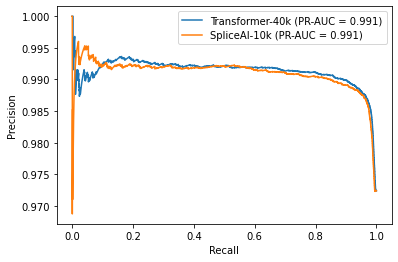

In [32]:
precision1, recall1,t1 = precision_recall_curve(evaluation_set_target, evaluation_set_results_1)
auc_1 = average_precision_score(evaluation_set_target, evaluation_set_results_1)
precision2, recall2,t2 = precision_recall_curve(evaluation_set_target, evaluation_set_results_2)
auc_2 = average_precision_score(evaluation_set_target, evaluation_set_results_2)

#aucs_1.append(auc_1)
plt.plot(recall1, precision1, label=f"Transformer-40k (PR-AUC = {auc_1 :.3f})")
plt.plot(recall2, precision2, label=f"SpliceAI-10k (PR-AUC = {auc_2 :.3f})")
plt.ylabel("Precision")
plt.xlabel("Recall")

plt.legend()
#plt.savefig('../Results/transformer_delta_clinvar_splice_variant_pr-auc.png',dpi=300,bbox_inches='tight')
plt.show()